In [1]:
from itertools import cycle,islice

from matplotlib import pylab as plt
import numpy as np
import sklearn
import sklearn.datasets

import torch
import torch.nn as nn
import torchvision
import torchdiffeq

import odenet
import odenet.models as models
import odenet.ode_models as ode_models
import odenet.plotting as plotting
import odenet.refine_train as refine_train

In [157]:
import importlib
importlib.reload(models)
importlib.reload(ode_models)
importlib.reload(refine_train)

<module 'odenet.refine_train' from '/home/ubuntu/afq/ODENet/odenet/refine_train.py'>

In [3]:
colors = np.array(list(islice(cycle(
    ['#377eb8', '#ff7f00', '#4daf4a',
     '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00']),
    int(max([1]) + 1))))

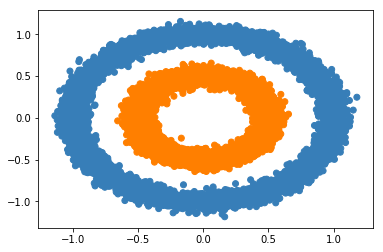

In [4]:
X,Y = sklearn.datasets.make_circles(n_samples=15000, factor=.5,
                                      noise=.05)
plt.scatter(X[:,0],X[:,1],color=colors[Y])

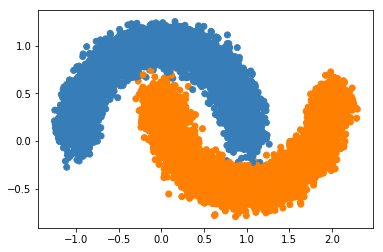

In [5]:
X,Y = sklearn.datasets.make_moons(n_samples=15000,noise=0.1)

plt.scatter(X[:,0],X[:,1],color=colors[Y])

In [6]:
def plot_pred(model):
    pred = torch.sigmoid(model( torch.tensor(X[:1000,:],dtype=torch.float32) ))
    P = pred.detach().numpy()
    P = np.array(np.around(P),dtype=np.int)
    plt.scatter(X[:1000,0],X[:1000,1],color=colors[list(P.flatten())])

In [7]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(X,dtype=torch.float),torch.tensor(Y,dtype=torch.float).reshape(-1,1))
loader = torch.utils.data.DataLoader(dataset,batch_size=64)

In [8]:
model_deep = models.DeepNet((2,4,4,4,1),Act=torch.nn.LeakyReLU)

In [13]:
model_shallow = models.ShallowNet(2,1,hidden=8,Act=torch.nn.LeakyReLU)
losses = refine_train.train_for_epochs(
    model_shallow, loader, loader, nn.BCEWithLogitsLoss(), 5, lr = 0.01)

Connected to device  cuda:0


RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_addmm

In [14]:
plt.semilogy(losses)
plt.show()
plot_pred(model_shallow)

NameError: name 'losses' is not defined

# Test a basic depth-wise ode

In [71]:
import copy

In [140]:
class ODEModel(torch.nn.Module):
    def __init__(self,
                 i_dim,
                 o_dim,
                 ode_width=4,
                 inside_width=4,
                 time_d=1,
                 Act=torch.nn.ReLU,
                 use_adjoint=False,
                 scheme='euler'):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(i_dim,ode_width),
            ode_models.ODEBlock(
                ode_models.ShallowODE(time_d,ode_width,ode_width,act=torch.nn.functional.leaky_relu),
                n_time_steps=time_d,
                scheme='euler',
                use_adjoint=use_adjoint),
            torch.nn.Linear(ode_width,o_dim),
        )
    def forward(self,x):
        # Missing sigmoid
        y = self.net(x)
        return y
    def refine(self):
        new = copy.deepcopy(self)
        new.net[1] = self.net[1].refine()
        return new

In [154]:
model = ODEModel(2,1,ode_width=2,inside_width=1, time_d=1,
                 Act=torch.nn.LeakyReLU,scheme='rk4', use_adjoint=False)

In [166]:
losses = refine_train.train_for_epochs(model, loader, loader, nn.BCEWithLogitsLoss(), 4,
                                       lr = 0.001)

Train Loss:  0.5
Test Loss:  0.5
Train Loss:  0.5
Test Loss:  0.5
Train Loss:  0.5
Test Loss:  0.5
Train Loss:  0.5
Test Loss:  0.5


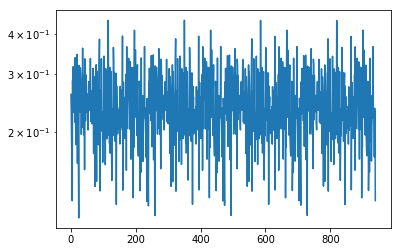

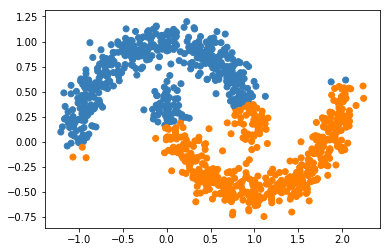

In [167]:
plt.semilogy(losses.losses)
plt.show()
plot_pred(model)

In [198]:
model = ODEModel(2,1,ode_width=3,inside_width=1, time_d=1,
                 Act=torch.nn.LeakyReLU,scheme='euler', use_adjoint=False)
losses = refine_train.train_adapt(model, loader, loader, nn.BCEWithLogitsLoss(), 16,
                                       lr = 0.01, N_refine=[1,2,4,8])

Random initialization checking accuracy metrics:
Train Accuracy:  0.5
Test Accuracy:  0.5
After Epoch:  0
Train Accuracy:  0.5
Test Accuracy:  0.5
**** Allocated refinment ****
Total params: 0.00M
************
ODEModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ODEBlock(
      (net): ShallowODE(
        (L1): LinearODE()
        (L2): LinearODE()
      )
    )
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)
After Epoch:  1
Train Accuracy:  0.5
Test Accuracy:  0.5
**** Allocated refinment ****
Total params: 0.00M
************
ODEModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ODEBlock(
      (net): ShallowODE(
        (L1): LinearODE()
        (L2): LinearODE()
      )
    )
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)
After Epoch:  2
Train Accuracy:  0.5
Test Accuracy:  0.5
After Epoch:  3
Train Accuracy:  0.5
Test Accuracy:  0.5
**** Allocated refinment ****


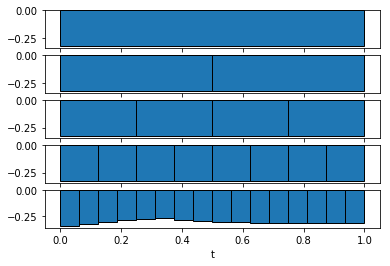

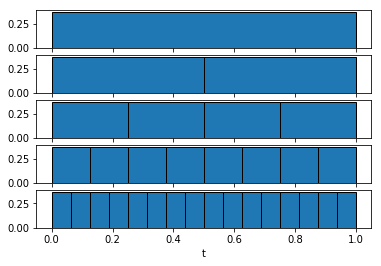

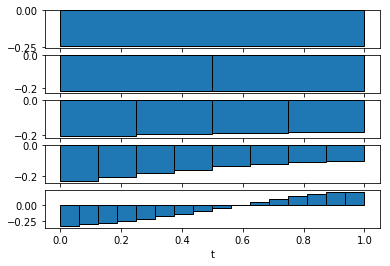

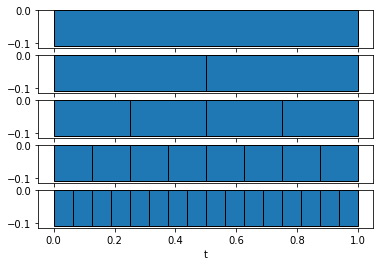

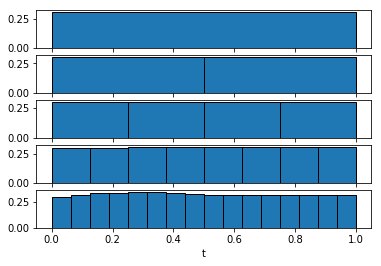

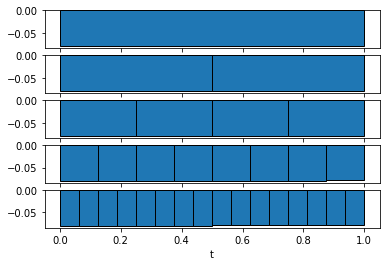

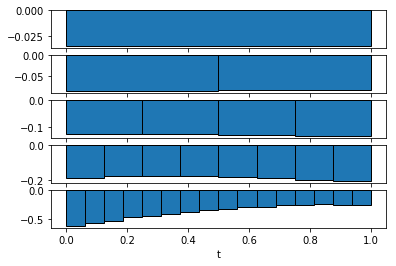

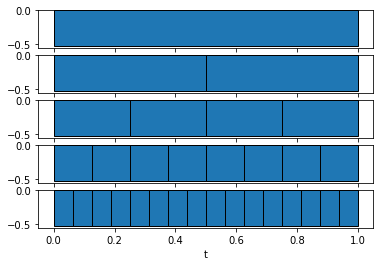

In [199]:
for i in range(2):
    for j in range(2):
        plotting.plot_weights_over_time(
            losses.model_list,
            lambda x : x.net[1].net.L1.weights[:,i,j],
            lambda x : x.net[1].ts)
        plotting.plot_weights_over_time(
            losses.model_list,
            lambda x : x.net[1].net.L2.weights[:,i,j],
            lambda x : x.net[1].ts)

In [200]:
for M in losses.model_list:
    print(M.net[1].net.L1.weights.shape)

torch.Size([1, 3, 3])
torch.Size([2, 3, 3])
torch.Size([4, 3, 3])
torch.Size([8, 3, 3])
torch.Size([16, 3, 3])


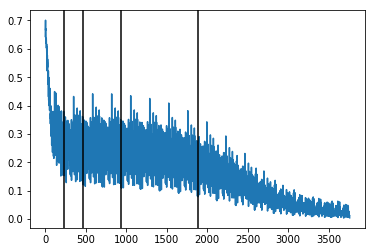

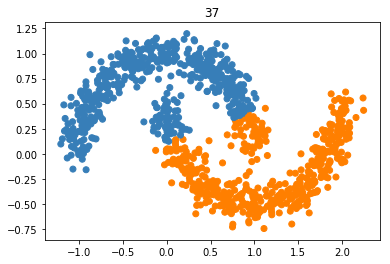

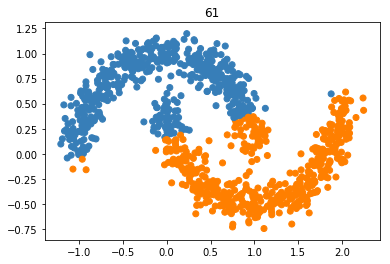

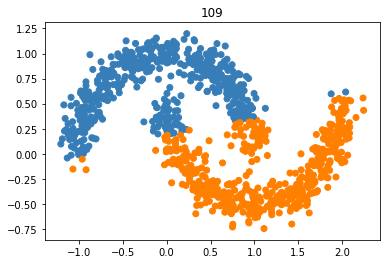

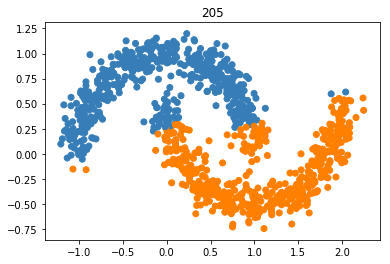

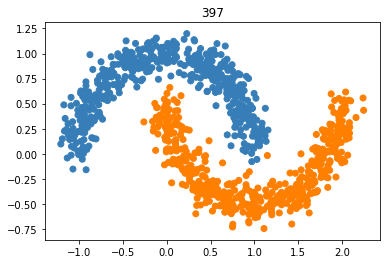

In [201]:
plt.plot(losses.losses)
for r in losses.refine_steps:
    plt.axvline(r,color='k')
plt.show()
for m in losses.model_list:
    plt.title(refine_train.count_parameters(m))
    plot_pred(m)
    plt.show()